In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pachner_traversal.utils import data_path, set_style, compute_rhat

set_style()

In [2]:
mcmc_result_path = data_path / "results" / "mcmc" / "generic_samples" / "20251004_1845"
assert mcmc_result_path.exists()

In [3]:
tet_map = {l: i for i, l in enumerate('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ')}

In [4]:
def get_mcmc_scores_df(result_path, metric='agg_score_alex_norm'):
    isos_df = pd.read_csv(result_path / 'isos_lists.csv')
    scores_df = pd.read_csv(result_path / 'composite_scores.csv', index_col=0)

    scores_series = scores_df[metric]
    scores_map = scores_series.to_dict()

    chain_scores_df = isos_df.apply(lambda x: x.map(scores_map), axis=1)
    return chain_scores_df

In [5]:
isos_df = pd.read_csv(mcmc_result_path / 'isos_lists.csv')
isos_df = isos_df[1000:]

In [6]:
metrics = [
    "agg_score_alex_norm",
    "agg_score_alex_deg",
    "agg_score_alex_det",
    "agg_score_edge_var",
    "agg_score_num_gen",
    "p_knotted",
    "count_unknotted",
]

mcmc_chain_scores = {}

for metric in metrics:
    mcmc_chain_scores_df = get_mcmc_scores_df(mcmc_result_path, metric)
    mcmc_chain_scores[metric] = mcmc_chain_scores_df
    rhat = compute_rhat(mcmc_chain_scores_df)[0]
    print(f'{metric:20} | Rhat: {rhat:.3f}')

agg_score_alex_norm  | Rhat: 1.003
agg_score_alex_deg   | Rhat: 1.004
agg_score_alex_det   | Rhat: 1.005
agg_score_edge_var   | Rhat: 1.006
agg_score_num_gen    | Rhat: 1.009
p_knotted            | Rhat: 1.009
count_unknotted      | Rhat: 1.005


In [8]:
for df_name in mcmc_chain_scores:
    mcmc_chain_scores[df_name].to_csv(mcmc_result_path / f'{df_name}_chains.csv')

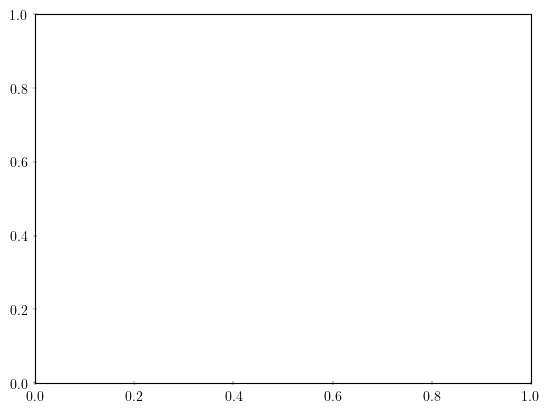

In [20]:
for df_name in mcmc_chain_scores:
    plt.hist(mcmc_chain_scores[df_name].values.flatten(), bins=100, density=True)
    plt.ylabel('Density')
    plt.xlabel('Score')
    plt.savefig(mcmc_result_path / f'{df_name}_hist.png', dpi=300)
    plt.cla()